<a href="https://colab.research.google.com/github/bharadwaj-vedula/Direct-Marketing-Optimisation/blob/main/Rebel_Foods_Modeling_MF_Sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
!pip install Optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 9.4 MB/s eta 0:00:00


In [2]:
import warnings

# Ignore all warnings
warnings.filterwarnings('ignore')

In [3]:
import os
import pandas as pd
import numpy as np
from collections import Counter

import optuna

import seaborn as sns
import matplotlib.pyplot as plt

from xgboost import XGBRegressor

from sklearn.model_selection import train_test_split,KFold,cross_val_score
from sklearn.metrics import root_mean_squared_error as rmse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score

# Paths

In [4]:
class config:
  path = '/content/drive/MyDrive/Rebel Foods Assignment/DataScientist_CaseStudy_Dataset  (1) (1).xlsx'

In [5]:
df_dem = pd.read_excel(config.path,sheet_name = 'Soc_Dem')
df_actBalance = pd.read_excel(config.path,sheet_name = 'Products_ActBalance')
df_inflowOutflow = pd.read_excel(config.path, sheet_name = 'Inflow_Outflow')
df_salesRevenue = pd.read_excel(config.path,sheet_name = 'Sales_Revenues')

# Mutual Fund Regression Model

### Data Perp

1. NaNs can be filled with zero as most of them are realted to count and balances.



In [6]:
mf_clients = df_salesRevenue.loc[df_salesRevenue['Sale_MF'] == 1]['Client'].tolist()

In [7]:
df = df_dem.merge(df_actBalance, how= 'inner',on='Client').merge(df_inflowOutflow,how= 'inner',on='Client').merge(df_salesRevenue,how= 'inner',on='Client')


In [8]:
df = df.loc[df['Sale_MF'] == 1]
print(df.shape)

(193, 36)


In [9]:
sexMapping = {'F':np.int16(0),'M':np.int16(1)}
df['Sex'] = df['Sex'].map(sexMapping)
df.fillna(0,inplace= True)

In [10]:
df.drop(columns = ['Sale_CC', 'Sale_CL','Sale_MF', 'Revenue_CC', 'Revenue_CL'], inplace= True)

In [11]:
df.columns

Index(['Client', 'Sex', 'Age', 'Tenure', 'Count_CA', 'Count_SA', 'Count_MF',
       'Count_OVD', 'Count_CC', 'Count_CL', 'ActBal_CA', 'ActBal_SA',
       'ActBal_MF', 'ActBal_OVD', 'ActBal_CC', 'ActBal_CL', 'VolumeCred',
       'VolumeCred_CA', 'TransactionsCred', 'TransactionsCred_CA', 'VolumeDeb',
       'VolumeDeb_CA', 'VolumeDebCash_Card', 'VolumeDebCashless_Card',
       'VolumeDeb_PaymentOrder', 'TransactionsDeb', 'TransactionsDeb_CA',
       'TransactionsDebCash_Card', 'TransactionsDebCashless_Card',
       'TransactionsDeb_PaymentOrder', 'Revenue_MF'],
      dtype='object')

## Train Test Split

In [12]:
df_train , df_test = train_test_split( df, test_size= 0.2)

In [13]:
Q1 = df_train['Revenue_MF'].quantile(0.25)
Q3 = df_train['Revenue_MF'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print(IQR)
print(lower_bound)
print(upper_bound)

7.634955357142857
-10.197924107142857
20.341897321428572


In [14]:
print(df_train.shape)
df_train = df_train[(df_train['Revenue_MF'] >= lower_bound) & (df_train['Revenue_MF'] <= upper_bound)]
print(df_train.shape)

(154, 31)
(136, 31)


In [15]:
X = df_train.iloc[:,1:-1]
y = df_train.iloc[:,-1]

y_transformed = np.log1p(y)

In [16]:
X_test = df_test.iloc[:,1:-1]
y_test = df_test.iloc[:,-1]

y_test_transformed = np.log1p(y_test)
print(X_test.shape,y_test.shape)

(39, 29) (39,)


# Hyperparameter

In [17]:
def objective_regressor(trial):
    """
    Objective function for Optuna to optimize for XGBRegressor.
    It trains an XGBoost Regressor with suggested hyperparameters and returns the
    cross-validated negative RMSE score (to be maximized by Optuna).
    """
    param = {
        'objective': 'reg:squarederror',
        'eval_metric': 'mae',
        'booster': trial.suggest_categorical('booster', ['gbtree', 'dart']),
        'tree_method': 'hist',
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),

        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.6, 1.0),
        'colsample_bynode': trial.suggest_float('colsample_bynode', 0.6, 1.0),

        'min_child_weight': trial.suggest_float('min_child_weight', 1e-2, 10.0, log=True),
        'gamma': trial.suggest_float('gamma', 1e-8, 0.5, log=True),
        'lambda': trial.suggest_float('lambda', 1e-8, 100.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-8, 100.0, log=True),
        'random_state': 2025,
        'n_jobs': -1,
        'early_stopping_rounds':100
    }

    if param['booster'] == 'dart':
        param['sample_type'] = trial.suggest_categorical('sample_type', ['uniform', 'weighted'])
        param['normalize_type'] = trial.suggest_categorical('normalize_type', ['tree', 'forest'])
        param['rate_drop'] = trial.suggest_float('rate_drop', 0.0, 0.5)
        param['skip_drop'] = trial.suggest_float('skip_drop', 0.0, 0.5)

    kf = KFold(n_splits=5, shuffle=True, random_state=2025)
    mae_scores = []

    for train_index, val_index in kf.split(X, y_transformed):
        X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[val_index]
        y_train_fold, y_val_fold = y_transformed.iloc[train_index], y_transformed.iloc[val_index]

        model = XGBRegressor(**param)

        model.fit(X_train_fold, y_train_fold,
                  eval_set=[(X_val_fold, y_val_fold)],
                  verbose=False)

        val_preds_transformed = model.predict(X_val_fold)

        # inverse transform the target variables
        val_preds_original_scale = np.expm1(val_preds_transformed)
        val_preds_original_scale[val_preds_original_scale < 0] = 0

        y_val_orig_for_rmse = y.iloc[val_index]

        # Calculate RMSE for the fold
        s = mae(y_val_orig_for_rmse, val_preds_original_scale)
        mae_scores.append(s)

    return np.mean(mae_scores)

In [ ]:
study_regressor = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=2025))
print("Starting Optuna hyperparameter tuning for XGBRegressor...")
study_regressor.optimize(objective_regressor, n_trials=50, show_progress_bar=True)
print("Optuna tuning complete.")


In [19]:
# --- 4. Get and Evaluate the Best Model ---

print("\nBest trial (XGBRegressor optimization):")
trial_regressor = study_regressor.best_trial

# Optuna stores the negative RMSE, so convert back to positive RMSE for display
print(f"  Value (Mean CV MAE): {-trial_regressor.value:.4f}")
print("  Best Parameters:")
for key, value in trial_regressor.params.items():
    print(f"    {key}: {value}")


Best trial (XGBRegressor optimization):
  Value (Mean CV MAE): -2.9738
  Best Parameters:
    booster: dart
    n_estimators: 619
    learning_rate: 0.2552045567586908
    max_depth: 8
    subsample: 0.8223641526121315
    colsample_bytree: 0.7552493766550321
    colsample_bylevel: 0.8555057766119323
    colsample_bynode: 0.9430128419689435
    min_child_weight: 0.2793761821809969
    gamma: 1.890688889100821e-06
    lambda: 80.43790488137243
    alpha: 0.14605884520896179
    sample_type: weighted
    normalize_type: tree
    rate_drop: 0.007892492848136881
    skip_drop: 0.012423753306300293


In [20]:
best_params_regressor = trial_regressor.params
final_model_regressor = XGBRegressor(**best_params_regressor,
                                         objective='reg:squarederror', # Ensure objective is set
                                         eval_metric='mae', # Eval metric for fitting
                                         early_stopping_rounds = 100,
                                          random_state=2025, n_jobs=-1)

print("\nTraining final XGBRegressor model with best parameters...")
final_model_regressor.fit(X, y_transformed,
                          eval_set=[(X_test, y_test_transformed)],
                          verbose=True)

print("\nEvaluating final XGBRegressor model on test set:")

y_test_preds_transformed = final_model_regressor.predict(X_test)

# inverse transform the target variable
y_test_preds_original_scale = np.expm1(y_test_preds_transformed)

# Calculate regression metrics
test_rmse = np.sqrt(mse(y_test, y_test_preds_original_scale))
test_mae = mae(y_test, y_test_preds_original_scale)
test_r2 = r2_score(y_test, y_test_preds_original_scale)

print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Test R-squared: {test_r2:.4f}")


Training final XGBRegressor model with best parameters...
[0]	validation_0-mae:1.02814
[1]	validation_0-mae:1.02517
[2]	validation_0-mae:1.02717
[3]	validation_0-mae:1.02696
[4]	validation_0-mae:1.03070
[5]	validation_0-mae:1.02909
[6]	validation_0-mae:1.02770
[7]	validation_0-mae:1.03050
[8]	validation_0-mae:1.03491
[9]	validation_0-mae:1.04219
[10]	validation_0-mae:1.04313
[11]	validation_0-mae:1.04538
[12]	validation_0-mae:1.04938
[13]	validation_0-mae:1.05729
[14]	validation_0-mae:1.06248
[15]	validation_0-mae:1.06567
[16]	validation_0-mae:1.06552
[17]	validation_0-mae:1.06527
[18]	validation_0-mae:1.06739
[19]	validation_0-mae:1.06512
[20]	validation_0-mae:1.06566
[21]	validation_0-mae:1.06866
[22]	validation_0-mae:1.06646
[23]	validation_0-mae:1.06643
[24]	validation_0-mae:1.06974
[25]	validation_0-mae:1.07088
[26]	validation_0-mae:1.07003
[27]	validation_0-mae:1.06917
[28]	validation_0-mae:1.07001
[29]	validation_0-mae:1.07369
[30]	validation_0-mae:1.07056
[31]	validation_0-mae

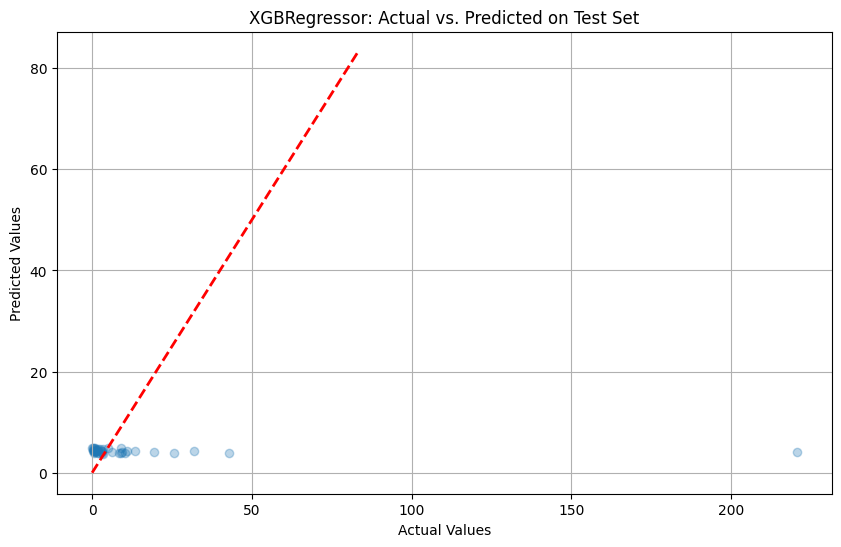

In [23]:
# Plotting actual vs. predicted values for visual inspection
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_preds_original_scale, alpha=0.3)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2) # Perfect prediction line
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("XGBRegressor: Actual vs. Predicted on Test Set")
plt.grid(True)
plt.show()

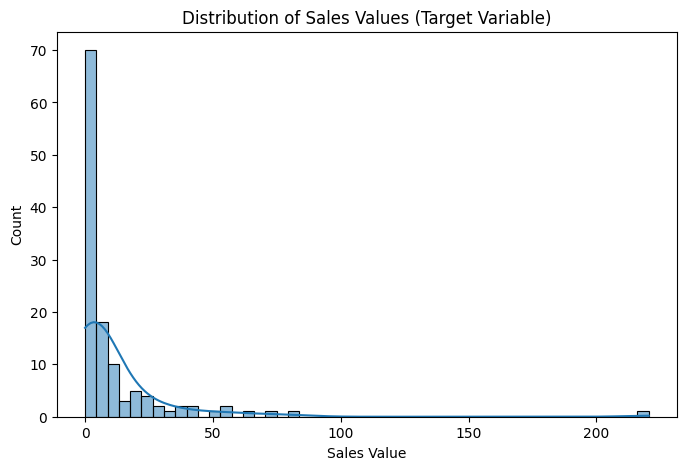

In [89]:
import seaborn as sns
plt.figure(figsize=(8, 5))
sns.histplot(y_train, bins=50, kde=True)
plt.title("Distribution of Sales Values (Target Variable)")
plt.xlabel("Sales Value")
plt.ylabel("Count")
plt.show()

# Save Model

In [23]:
final_model_regressor.save_model('/content/drive/MyDrive/Rebel Foods Assignment/Models/XGBRegressor_MF.json')